In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display

from scipy import signal

# Options

In [2]:
r = ['SEA']
month = 'Jan' #options are Jan, Apr, Jul, Oct
time = '20160'
length_simulation = 60 #days
diagnostic = 'SpeciesConc'


In [47]:
test_ds = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan/mod_output/GEOSChem.{diagnostic}.{time}*', combine = 'by_coords')




In [27]:
T_p_ds = xr.open_mfdataset('/net/geoschem/data/gcgrid/data/ExtData/GEOS_0.5x0.625/MERRA2/2016/*/MERRA2.2016*.I3.05x0625.nc4')




In [65]:
pressure_ds = utils.pressure_ds

In [32]:
T_p_ds = T_p_ds.groupby('time.date').mean(dim = 'time').rename({'date':'time'})

In [29]:
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [60]:
### convert to correct units
def ppb_to_ug(ds, species_to_convert, mw_species_list, P, T):
    '''Convert species to ug/m3 from ppb'''
    R = 8.314 #J/K/mol
    mol_per_m3= (P / (T * R)) #Pa/K/(J/K/mol) = mol/m3
    
    for spec in species_to_convert:
        attrs = ds[spec].attrs
        x = ds[spec]*mw_species_list[spec]*mol_per_m3*1e-3 #ppb*g/mol*mol/m3*ug/ng
        ds[spec] = x
        ds[spec].attrs['units'] = 'μg m-3'
    return(x)



In [66]:
pressure_ds

<xarray.DataArray 'Pressure' (lev: 72)>
array([1.00565e+05, 9.90408e+04, 9.75122e+04, 9.59837e+04, 9.44553e+04,
       9.29268e+04, 9.13984e+04, 8.98701e+04, 8.83418e+04, 8.68135e+04,
       8.52852e+04, 8.37570e+04, 8.19743e+04, 7.96822e+04, 7.71354e+04,
       7.45890e+04, 7.20429e+04, 6.94969e+04, 6.63146e+04, 6.24967e+04,
       5.86793e+04, 5.48628e+04, 5.10475e+04, 4.72335e+04, 4.34212e+04,
       3.96112e+04, 3.58038e+04, 3.13966e+04, 2.67087e+04, 2.26745e+04,
       1.92587e+04, 1.63661e+04, 1.39115e+04, 1.18250e+04, 1.00514e+04,
       8.54390e+03, 7.25580e+03, 6.14960e+03, 5.20160e+03, 4.39100e+03,
       3.69930e+03, 3.10890e+03, 2.60490e+03, 2.17610e+03, 1.81240e+03,
       1.50500e+03, 1.24600e+03, 1.02850e+03, 8.45600e+02, 6.91800e+02,
       5.63200e+02, 4.56200e+02, 3.67700e+02, 2.94800e+02, 2.35300e+02,
       1.86800e+02, 1.47600e+02, 1.16000e+02, 9.07000e+01, 7.06000e+01,
       5.46000e+01, 4.20000e+01, 3.22000e+01, 2.45000e+01, 1.85000e+01,
       1.40000e+01, 1.05000e+01, 7.80000e+00, 5.70000e+00, 4.00000e+00,
       2.60000e+00, 1.50000e+00])
Coordinates:
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 ... 63 64 65 66 67 68 69 70 71 72

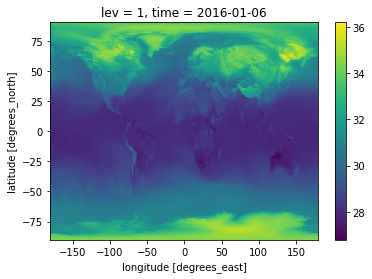

In [67]:
(pressure_ds/ (T_p_ds['T']*12.011)).isel(time = 5, lev = 0).plot()

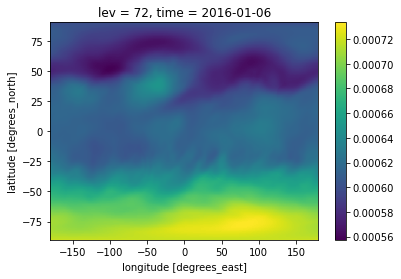

In [68]:
(pressure_ds/ (T_p_ds['T']*12.011)).isel(time = 5, lev = -1).plot()

In [69]:
mw_BC = {'SpeciesConc_BCPI':12.011}

In [70]:
test_out = ppb_to_ug(test_ds, ['SpeciesConc_BCPI'], mw_BC, pressure_ds, T_p_ds['T'])

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/pandas/core/indexes/base.py:347: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_ndarray, lidx, ridx = libjoin.inner_join_indexer(sv, ov)


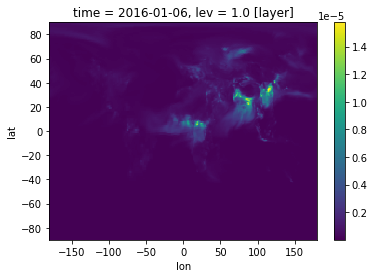

In [71]:
(test_out*1e9).isel(lev = 0, time = 5).plot()

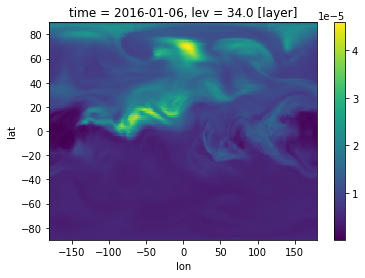

In [72]:
(test_out*1e9).isel(lev = 33, time = 5).plot()

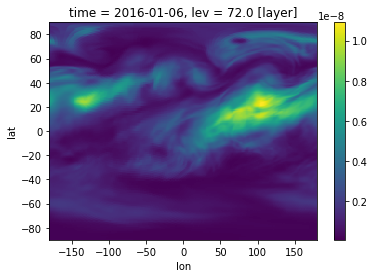

In [73]:
(test_out*1e9).isel(lev = -1, time = 5).plot()

## Import data

In [3]:
dict_conc = {}
dict_emis = {}

#15x step for GF
dict_conc['SEA_step'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/SEA/Jan/mod_output/GEOSChem.{diagnostic}.{time}*', combine = 'by_coords')
#pulse run
dict_conc['SEA_pulse'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.{diagnostic}.{time}*', combine = 'by_coords')
#1.5e-10 addition run
dict_conc['SEA_add'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/SEA_addition/Jan/mod_output/GEOSChem.{diagnostic}.{time}*', combine = 'by_coords')
#15x step for GF
dict_emis['SEA_step'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/SEA/Jan/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')
#pulse run
dict_emis['SEA_pulse'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')
#1.5e-10 addition run
dict_emis['SEA_add'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/SEA_addition/Jan/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')



In [4]:

dict_conc['base'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan/mod_output/GEOSChem.{diagnostic}.{time}*', combine = 'by_coords', engine = 'netcdf4')
dict_emis['base'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords', engine = 'netcdf4')

In [5]:
ds_conc = xr.concat([dict_conc[r] for r in dict_conc.keys()], pd.Index([r for r in dict_conc.keys()], name='run'))
ds_emis = xr.concat([dict_emis[r] for r in dict_emis.keys()], pd.Index([r for r in dict_emis.keys()], name='run'))

In [6]:
ds_conc['BC_total'] = ds_conc['SpeciesConc_BCPI'] + ds_conc['SpeciesConc_BCPO']

utils.combine_BC(ds_emis)

In [7]:
### convert to correct units
def ppb_to_ug(ds, species_to_convert, mw_species_list, stp_p = 101325, stp_t = 298.):
    '''Convert species to ug/m3 from ppb'''
    R = 8.314 #J/K/mol
    mol_per_m3= (stp_p / (stp_t * R)) #Pa/K/(J/K/mol) = mol/m3
    
    for spec in species_to_convert:
        attrs = ds[spec].attrs
        x = ds[spec]*mw_species_list[spec]*mol_per_m3*1e-3 #ppb*g/mol*mol/m3*ug/ng
        ds[spec] = x
        ds[spec].attrs['units'] = 'μg m-3'
    return(x)

mw_BC = {'BC_total':12.011}

ds_conc['BC_total'] = ds_conc['BC_total']*1e9 #convert mol/mol to ppb
ppb_to_ug(ds_conc, ['BC_total'], mw_BC)

print('Converted units')

Converted units


In [8]:
ds_emis = utils.fix_area_ij_latlon(ds_emis)
ds_conc= utils.fix_area_ij_latlon(ds_conc)

## Add height to data

In [19]:
height_ds = utils.height_ds

In [18]:
ds_conc['lev'] = height_ds['lev']

NameError: name 'ds_conc' is not defined

In [13]:
#ds_emis = xr.merge([ds_emis, height_ds], join = 'inner')
ds_conc = xr.merge([ds_conc, height_ds], join = 'inner')

In [14]:
sec_day = 86400

## Define our Conc Difference and Initial Forcing

In [15]:
runs = ['SEA_pulse','SEA_step', 'SEA_add']

In [16]:
poll_name = 'BC_total'
dt = 1 #day

In [17]:
ds_emis = ds_emis.isel(lev = -1) #select surface since we only have surface emissions

In [18]:
#shift our time so that it is halfway through the day to represent the daily mean
utils.switch_conc_time(ds_conc)

In [23]:
#calculate the dc/dt
dict_dc_dt = {}
dict_dc_dt_gmean = {}
f0 = {}
for r in ['SEA_step', 'SEA_add']: #,
    #change in concentration over time
    dict_dc_dt_gmean[r] = utils.calc_δc_δt_mean(ds_conc, poll_name, r, 'base')
    dict_dc_dt_gmean[r] = dict_dc_dt_gmean[r].assign_coords(time = np.arange(.5,len(dict_dc_dt_gmean[r]['time'])+.5))

    dict_dc_dt[r] = utils.calc_δc_δt(ds_conc, poll_name, r, 'base')
    dict_dc_dt[r] = dict_dc_dt[r].assign_coords(time = np.arange(.5,len(dict_dc_dt[r]['time'])+.5))

for r in ['SEA_step', 'SEA_add']:
    #f0 calculation    
    f0[r] = (ds_emis['EmisBC_Total'].weighted(ds_emis['area'].fillna(0)).sum(dim = ['lat','lon']).sel(run = r) - 
        ds_emis['EmisBC_Total'].weighted(ds_emis['area'].fillna(0)).sum(dim = ['lat','lon']).sel(run = 'base')).isel(time = 0).values 
    
f0['SEA_pulse'] = (ds_emis['EmisBC_Total'].weighted(ds_emis['area'].fillna(0)).sum(dim = ['lat','lon']).sel(run = 'SEA_pulse') - 
        ds_emis['EmisBC_Total'].weighted(ds_emis['area'].fillna(0)).sum(dim = ['lat','lon']).sel(run = 'base')).isel(time = 0).values

In [24]:
#create the dataset of our dc/dt
dc_dt = xr.concat([dict_dc_dt[r] for r in dict_dc_dt.keys()], pd.Index([r for r in dict_dc_dt.keys()], name='run'))
dc_dt_gmean = xr.concat([dict_dc_dt_gmean[r] for r in dict_dc_dt_gmean.keys()], pd.Index([r for r in dict_dc_dt_gmean.keys()], name='run'))
dc_dt = dc_dt.rename({'time':'s'})
dc_dt_gmean = dc_dt_gmean.rename({'time':'s'})

In [25]:
#calculate the Green's function as dc/dt/f0
G_dict = {}
G_dict_gmean = {}
for r in ['SEA_step', 'SEA_add']:
    G_dict[r] = dc_dt.sel(run = r)/f0[r]#[:,np.newaxis, np.newaxis, np.newaxis]
    G_dict_gmean[r] = dc_dt_gmean.sel(run = r)/f0[r]

In [26]:
G_dict['SEA_pulse'] = (ds_conc.sel(run ='SEA_pulse')-ds_conc.sel(run ='base'))['BC_total']/f0['SEA_pulse']
G_dict_gmean['SEA_pulse'] = (ds_conc.sel(run ='SEA_pulse')-ds_conc.sel(run ='base'))['BC_total'].weighted(ds_conc['area'].sel(run = 'base').fillna(0)*
                                                                                                          ds_conc['dz'].fillna(0)).mean(['lat','lon','lev'])/f0['SEA_pulse']

In [27]:
G_dict_gmean['SEA_pulse'] = G_dict_gmean['SEA_pulse'].rename({'time':'s'})
G_dict_gmean['SEA_pulse']['s'] = G_dict_gmean['SEA_step']['s'].values

In [28]:
G_dict['SEA_pulse'] = G_dict['SEA_pulse'].rename({'time':'s'})
G_dict['SEA_pulse']['s'] = G_dict['SEA_step']['s'].values

In [29]:
#convert to datasets, calculate mean GF
G = xr.concat([G_dict[r] for r in G_dict.keys()], pd.Index([r for r in G_dict.keys()], name='run'))
G_mean = xr.concat([G_dict_gmean[r] for r in G_dict_gmean.keys()], pd.Index([r for r in G_dict_gmean.keys()], name='run'))


In [30]:
G_ds = xr.open_dataset(f'Outputs/G_all_loc_all_times_BC_total.nc4', chunks = 'auto')

In [120]:
G_mean_test_ds = G_ds.weighted(ds_conc['area'].sel(run = 'base').isel(time = 0)).mean(dim = ['lat','lon'])['BC_total']

In [121]:
G_mean_full_ds = xr.open_dataset('Outputs/G_mean_all_loc_all_times_BC_total.nc4')

In [119]:
(ds_conc.sel(run = 'SEA_pulse')- ds_conc.sel(run = 'SEA_base'))['BC_total'].weighted(
    (ds_conc['area']*ds_conc['dz']).sel(run = 'base').isel(time = 0)).mean(dim = ['lat','lon','lev'])

,Array,Chunk
Bytes,1.64 GiB,28.48 MiB
Shape,"(59, 72, 180, 288)","(1, 72, 180, 288)"
Count,4593 Tasks,59 Chunks
Type,float64,numpy.ndarray


In [ ]:
(dict_conc[r + '_' + m]-dict_conc[f'base_{m}'])['BC_total'].weighted(
            dict_conc[f'base_{m}']['area'].fillna(0)*height_ds['dz'].fillna(0)).mean(['lat','lon','lev'])/f0[r + '_' + m]

OSError: [Errno -51] NetCDF: Unknown file format: b'/net/fs11/d0/emfreese/BC-IRF/Outputs/G_all_loc_all_times_BC_total.nc4'

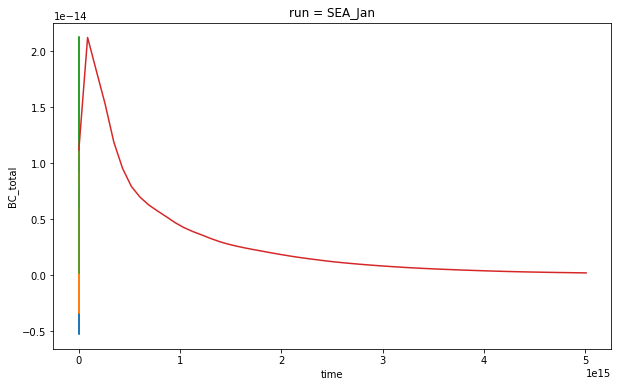

In [123]:
fig, ax = plt.subplots(figsize = [10,6])
G_mean.sel(run = 'SEA_step').plot(label = 'Multiplied Step')
G_mean.sel(run = 'SEA_add').plot(label = 'Added Step')
(G_mean.sel(run = 'SEA_pulse')).plot(label = 'Pulse')
G_mean_full_ds.sel(run = 'SEA_Jan')['BC_total'].plot(label = 'Mean Full')
G_mean_test_ds.sel(run = 'SEA_Jan').plot(label = 'Mean Test')
plt.legend()
plt.title('Comparing Different Pulse and Step Options', fontsize = 15)
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Green\'s Function', fontsize = 13)

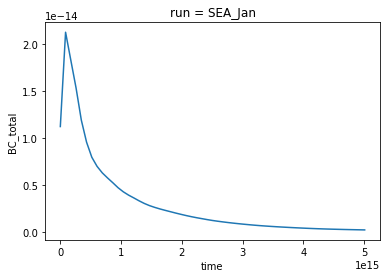

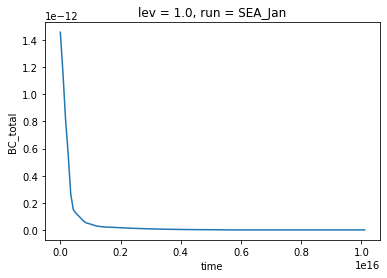

In [43]:
G_mean_test_ds.sel(run = 'SEA_Jan').plot()

Text(0, 0.5, "Green's Function")

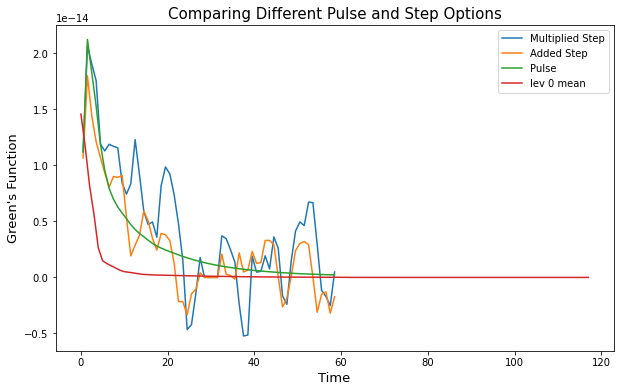

In [61]:
fig, ax = plt.subplots(figsize = [10,6])
G_mean.sel(run = 'SEA_step').plot(label = 'Multiplied Step')
G_mean.sel(run = 'SEA_add').plot(label = 'Added Step')
(G_mean.sel(run = 'SEA_pulse')).plot(label = 'Pulse')
plt.plot(G_mean_test_ds.sel(run = 'SEA_Jan'), label = 'lev 0 mean')
plt.legend()
plt.title('Comparing Different Pulse and Step Options', fontsize = 15)
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Green\'s Function', fontsize = 13)

## Compare convolution to the actual 2x output

In [93]:
#emis = kg/day
#conc = μg m-3

In [106]:
#2x pulse for GF
x2_emis = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_2x/SEA/Jan/mod_output/GEOSChem.Emissions.2016*', combine = 'by_coords')
#base
base_emis = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan/mod_output/GEOSChem.Emissions.2016*', combine = 'by_coords')


In [107]:
utils.combine_BC(x2_emis)
utils.combine_BC(base_emis)

In [108]:
x2_conc = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_2x/SEA/Jan/mod_output/GEOSChem.SpeciesConc.2016*', combine = 'by_coords')
base_conc = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan/mod_output/GEOSChem.SpeciesConc.2016*', combine = 'by_coords')

In [109]:
x2_conc['BC_total'] = x2_conc['SpeciesConc_BCPI'] + x2_conc['SpeciesConc_BCPO']
base_conc['BC_total'] = base_conc['SpeciesConc_BCPI'] + base_conc['SpeciesConc_BCPO']

In [110]:
utils.fix_area_ij_latlon(x2_emis)
utils.fix_area_ij_latlon(base_emis)


<xarray.Dataset>
Dimensions:            (lon: 288, lat: 180, time: 59, bounds: 2, lev: 72)
Coordinates:
  * lon                (lon) float64 -179.4 -178.1 -176.9 ... 176.9 178.1 179.4
  * lat                (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lev                (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 69.0 70.0 71.0 72.0
  * time               (time) datetime64[ns] 2016-01-01 ... 2016-02-28
Dimensions without coordinates: bounds
Data variables: (12/13)
    lon_bnds           (time, lon, bounds) float64 dask.array<chunksize=(1, 288, 2), meta=np.ndarray>
    lat_bnds           (time, lat, bounds) float64 dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
    area               (time, lat, lon) float64 dask.array<chunksize=(1, 180, 288), meta=np.ndarray>
    EmisBCPI_Aircraft  (time, lev, lat, lon) float64 dask.array<chunksize=(1, 72, 180, 288), meta=np.ndarray>
    EmisBCPI_Anthro    (time, lev, lat, lon) float64 dask.array<chunksize=(1, 72, 180, 288), meta=np.ndarray>
    EmisBCPI_BioBurn   (time, lat, lon) float64 dask.array<chunksize=(1, 180, 288), meta=np.ndarray>
    ...                 ...
    EmisBCPI_Total     (time, lev, lat, lon) float64 dask.array<chunksize=(1, 72, 180, 288), meta=np.ndarray>
    EmisBCPO_Anthro    (time, lev, lat, lon) float64 dask.array<chunksize=(1, 72, 180, 288), meta=np.ndarray>
    EmisBCPO_BioBurn   (time, lat, lon) float64 dask.array<chunksize=(1, 180, 288), meta=np.ndarray>
    EmisBCPO_Ship      (time, lat, lon) float64 dask.array<chunksize=(1, 180, 288), meta=np.ndarray>
    EmisBCPO_Total     (time, lev, lat, lon) float64 dask.array<chunksize=(1, 72, 180, 288), meta=np.ndarray>
    EmisBC_Total       (time, lev, lat, lon) float64 dask.array<chunksize=(1, 72, 180, 288), meta=np.ndarray>

In [111]:
area = base_emis['area']

In [112]:
emis_dif = (x2_emis-base_emis)['EmisBC_Total'].weighted(area_ds['area']).sum(dim = ['lat','lon'])

In [113]:
emis_dif = emis_dif.isel(lev = -1)

In [114]:
### convert to correct units
def ppb_to_ug(ds, species_to_convert, mw_species_list, stp_p = 101325, stp_t = 298.):
    '''Convert species to ug/m3 from ppb'''
    R = 8.314 #J/K/mol
    mol_per_m3= (stp_p / (stp_t * R)) #Pa/K/(J/K/mol) = mol/m3
    
    for spec in species_to_convert:
        attrs = ds[spec].attrs
        x = ds[spec]*mw_species_list[spec]*mol_per_m3*1e-3 #ppb*g/mol*mol/m3*ug/ng
        ds[spec] = x
        ds[spec].attrs['units'] = 'μg m-3'
    return(x)

mw_BC = {'BC_total':12.011}

x2_conc['BC_total'] = x2_conc['BC_total']*1e9 #convert mol/mol to ppb
ppb_to_ug(x2_conc, ['BC_total'], mw_BC)

base_conc['BC_total'] = base_conc['BC_total']*1e9 #convert mol/mol to ppb
ppb_to_ug(base_conc, ['BC_total'], mw_BC)
print('Converted units')

Converted units


In [ ]:
G_mean

In [103]:
conv = {}
for run in G_mean.run.values:
    conv[run] = signal.convolve(np.array(G_mean.sel(run = run)) , np.array(emis_dif.values), mode = 'full')


In [104]:
conv['mean_test'] = signal.convolve(np.array(G_mean_test_ds.sel(run = 'SEA_Jan')) , np.array(emis_dif.values), mode = 'full')
conv['full_mean'] = signal.convolve(np.array(G_mean_full_ds.sel(run = 'SEA_Jan')['BC_total']) , np.array(emis_dif.values), mode = 'full')

In [88]:
conv_ds = xr.concat((conv[r] for r in ['SEA_step','SEA_pulse','SEA_add']), pd.Index([r for r in ['SEA_step','SEA_pulse','SEA_add']], name = 'run'))

TypeError: can only concatenate xarray Dataset and DataArray objects, got <class 'numpy.ndarray'>

In [69]:
conv.keys()

dict_keys(['SEA_step', 'SEA_add', 'SEA_pulse', 'mean_test', 'full_mean'])

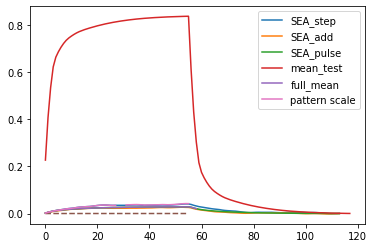

In [105]:
fig,ax = plt.subplots()
for r in ['SEA_step', 'SEA_add', 'SEA_pulse', 'mean_test', 'full_mean']:
    plt.plot(conv[r], label = r)

plt.plot((x2_conc - base_conc)['BC_total'].weighted(area_ds['area'].fillna(0)*
                                                    ds_conc['dz'].fillna(0)).mean(['lat','lon','lev']), linestyle = '--')
plt.plot((((ds_conc.sel(run = 'SEA_step')-ds_conc.sel(run = 'base')).weighted(ds_conc['area'].sel(run = 'base').fillna(0)*
                                                                                                          ds_conc['dz'].fillna(0)).mean(['lat','lon','lev'])['BC_total'])/f0['SEA_step'])[:56].values*emis_dif.values, label = 'pattern scale')
plt.plot()
plt.legend()
#plt.xlim(0,55)

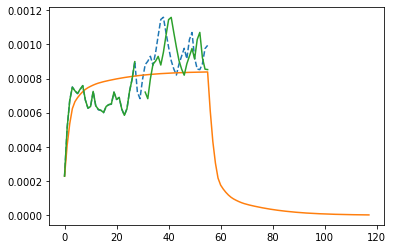

In [92]:
plt.plot((x2_conc - base_conc)['BC_total'].weighted(area_ds['area'].fillna(0)).mean(['lat','lon']).isel(lev = 0), linestyle = '--')
plt.plot(conv['mean_test'])
plt.plot((((ds_conc.sel(run = 'SEA_step')-ds_conc.sel(run = 'base')).weighted(ds_conc['area'].sel(run = 'base').fillna(0)).mean(['lat','lon'])['BC_total']).isel(lev = 0)/f0['SEA_step'])[:56].values*emis_dif.values, label = 'pattern scale')

